In [1]:
#Multiprocessing for Parallelism
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from dateutil.tz import *

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random

random.seed(42)
np.random.seed(42)

In [3]:
import calendar

def findDay(date):
	year, month, day = (int(i) for i in date.split('-')) 
	return calendar.weekday(year, month, day)

In [4]:
start_time = time.monotonic()

BASE_PATH = "data/"
data_site_solar_generation_path = BASE_PATH + 'Solar_Generation_sub.csv'
data_site_solar_generation = pd.read_csv(data_site_solar_generation_path)
X = data_site_solar_generation[['Month','Weekday','Hour','Minute','ApparentTemperature','Ghi']].to_numpy()
#X = np.hstack([weather_data["ApparentTemperature"].values.reshape(-1, 1),data_site_solar_generation[['Month','Weekday','Hour','Minute']].values])
print(np.shape(X))
print(type(X))

Y = data_site_solar_generation['SolarGeneration'].to_numpy()
init_Y_len = Y.shape[0]
print(np.shape(Y))
print(type(Y))

(34256, 6)
<class 'numpy.ndarray'>
(34256,)
<class 'numpy.ndarray'>


In [5]:
temp_irra_interpolatiiing_path = BASE_PATH + 'temp_irra_interpolatiiing_with_ghi.csv'
temp_irra_interpolatiiing = pd.read_csv(temp_irra_interpolatiiing_path)

##print("Before: ", X.shape[0])
init_x_len = X.shape[0]
X = np.resize(X,(init_x_len+(24*4),6))
##print("After: ", X.shape[0])

for i in range (24*4):
    X[init_x_len+i][0] = temp_irra_interpolatiiing['time'][i][5:7] # adding the Month
    X[init_x_len+i][1] = findDay(temp_irra_interpolatiiing['time'][i][0:10]) # adding the Weekday
    X[init_x_len+i][2] = temp_irra_interpolatiiing['time'][i][11:13] # adding the Hour
    X[init_x_len+i][3] = temp_irra_interpolatiiing['time'][i][14:16] # adding the Hour
    X[init_x_len+i][4] = temp_irra_interpolatiiing['temperature'][i] # adding the temperature to X data
    X[init_x_len+i][5] = temp_irra_interpolatiiing['GHI_est'][i] # adding the ghi
    #print(X[init_x_len+i])

Y = np.resize(Y,(init_Y_len+(24*4),1))

In [6]:
# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle = False) # , random_state=42
X_train2, X_val, Y_train2, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle = False) # , random_state=42
print("Train: ", np.max(X_train), " ", (X_train.shape))
#print("Val: ", np.max(X_val), " ", (X_val.shape))
print("Test: ", np.max(X_test), " ", (X_test.shape))
len_of_x_test_original = X_test.shape[0] - (24*4)
# print("X_train: ", np.max(X_train), " ", (X_train.shape))
# print("X_Test: ", np.max(X_test), " ", (X_test.shape))
# print("Y_Train: ", np.max(Y_train), " ", (Y_train.shape))
# print("Y_Test: ", np.max(Y_test), " ", (Y_test.shape))

Train:  1078.0   (27481, 6)
Test:  1091.0   (6871, 6)


In [7]:
def train_client_proc(client_data_tuple): #(Xc, yc) in enumerate(clients_data):
    model = HistGradientBoostingRegressor(max_iter=50).fit(client_data_tuple[0], client_data_tuple[1])
    return model

In [8]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 2
max_workers = 1
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_2_prosum_1_vCPU = np.mean(predictions, axis=0)
final_prediction_2_prosum_1_vCPU = np.where(final_prediction_2_prosum_1_vCPU>=0.0, final_prediction_2_prosum_1_vCPU, 0)
mae_2_prosum_1_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_2_prosum_1_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_2_prosum_1_vCPU))

In [9]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 4
max_workers = 1
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_4_prosum_1_vCPU = np.mean(predictions, axis=0)
final_prediction_4_prosum_1_vCPU = np.where(final_prediction_4_prosum_1_vCPU>=0.0, final_prediction_4_prosum_1_vCPU, 0)
mae_4_prosum_1_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_4_prosum_1_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_4_prosum_1_vCPU))

In [10]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 4
max_workers = 4
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_4_prosum_4_vCPU = np.mean(predictions, axis=0)
final_prediction_4_prosum_4_vCPU = np.where(final_prediction_4_prosum_4_vCPU>=0.0, final_prediction_4_prosum_4_vCPU, 0)
mae_4_prosum_4_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_4_prosum_4_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_4_prosum_4_vCPU))

In [11]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 6
max_workers = 6
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_6_prosum_6_vCPU = np.mean(predictions, axis=0)
final_prediction_6_prosum_6_vCPU = np.where(final_prediction_6_prosum_6_vCPU>=0.0, final_prediction_6_prosum_6_vCPU, 0)
mae_6_prosum_6_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_6_prosum_6_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_12_prosum_12_vCPU))

In [12]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 8
max_workers = 8
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_8_prosum_8_vCPU = np.mean(predictions, axis=0)
final_prediction_8_prosum_8_vCPU = np.where(final_prediction_8_prosum_8_vCPU>=0.0, final_prediction_8_prosum_8_vCPU, 0)
mae_8_prosum_8_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_8_prosum_8_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_12_prosum_12_vCPU))

In [13]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 10
max_workers = 8
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_10_prosum_8_vCPU = np.mean(predictions, axis=0)
final_prediction_10_prosum_8_vCPU = np.where(final_prediction_10_prosum_8_vCPU>=0.0, final_prediction_10_prosum_8_vCPU, 0)
mae_10_prosum_8_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_10_prosum_8_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_12_prosum_12_vCPU))

In [14]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 10
max_workers = 10
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_10_prosum_10_vCPU = np.mean(predictions, axis=0)
final_prediction_10_prosum_10_vCPU = np.where(final_prediction_10_prosum_10_vCPU>=0.0, final_prediction_10_prosum_10_vCPU, 0)
mae_10_prosum_10_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_10_prosum_10_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_12_prosum_12_vCPU))

In [15]:
# Step 1: Split training data across num_of_clients clients
num_of_clients = 12
max_workers = 12
clients_data = []
client_size = len(X_train) // num_of_clients
for i in range(num_of_clients):
    start = i * client_size
    end = (i + 1) * client_size if i < 3 else len(X_train)
    clients_data.append((X_train[start:end], Y_train[start:end]))

# Step 2: Each client trains its own HGBDT model
client_models = []
# Train all clients in parallel
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(train_client_proc, clients_data[j])
            for j in range(num_of_clients)
        ]
        for f in as_completed(futures):
            client_models.append(f.result())

# Step 3: Server aggregates predictions by averaging
predictions = []
for model in client_models:
    pred = model.predict(X_test)
    predictions.append(pred)

# Step 4: Average the predictions from all client models
final_prediction_12_prosum_12_vCPU = np.mean(predictions, axis=0)
final_prediction_12_prosum_12_vCPU = np.where(final_prediction_12_prosum_12_vCPU>=0.0, final_prediction_12_prosum_12_vCPU, 0)
mae_12_prosum_12_vCPU = []
for i, model in enumerate(client_models):
   for Y_predict_hgbrrr in model.staged_predict(X_val):
      mae_12_prosum_12_vCPU.append(mean_absolute_error(Y_val, Y_predict_hgbrrr))
#print(len(mae_12_prosum_12_vCPU))

In [16]:
# Fit/Train
hgbr = HistGradientBoostingRegressor(max_iter=50).fit(X_train, Y_train)

In [17]:
# Predict
Y_predict_hgbr = hgbr.predict(X_test)
Y_predict_hgbr = np.where(Y_predict_hgbr>=0.0, Y_predict_hgbr, 0)

In [18]:
mae_centralized = []
for Y_predict_hgbrr in hgbr.staged_predict(X_val):
   mae_centralized.append(mean_absolute_error(Y_val, Y_predict_hgbrr))
#print(len(mae_centralized))

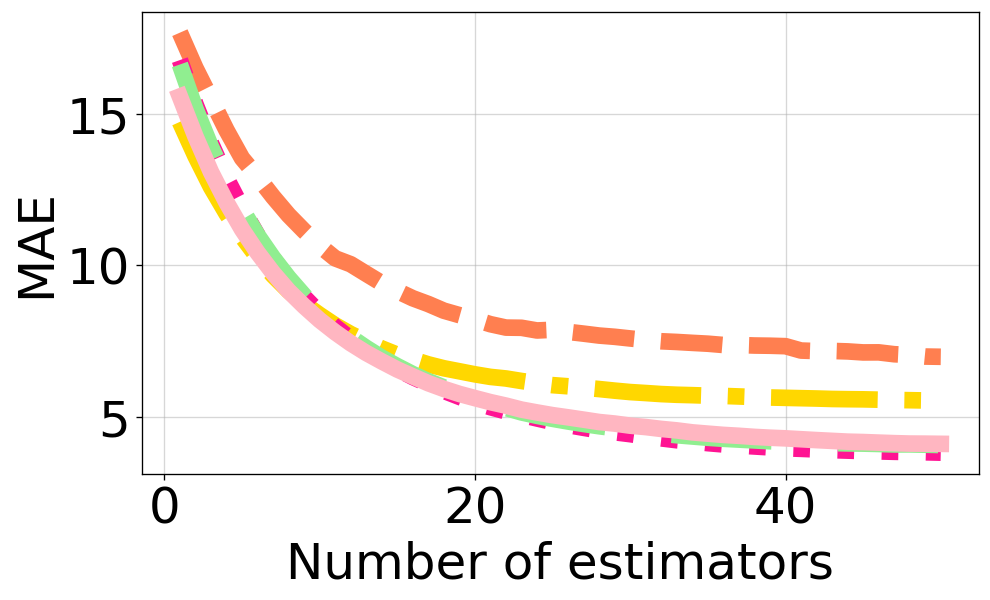

In [272]:
patterns = ['--', '-.', ':', 'dashdot', 'dashed']  # Different hatching styles

fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=30)
for i, model in enumerate(client_models):
    if i == 0:
        #print(len(model.train_score_))
        #plt.plot(np.arange(1, 50 + 1), mae_2_prosum_1_vCPU[0:50], color='cyan', linewidth=10, label = "FL-2$p_i$-on-1vCPU")
        #plt.plot(np.arange(1, 50 + 1), mae_4_prosum_1_vCPU[0:50], color='lightblue', linewidth=10, label = "FL-4$p_i$-on-1vCPU")
        plt.plot(np.arange(1, 50 + 1), mae_4_prosum_4_vCPU[0:50],  linestyle=patterns[0], color='coral', linewidth=10, label = "FL-4$p_i$-on-4vCPU")
        plt.plot(np.arange(1, 50 + 1), mae_6_prosum_6_vCPU[0:50], linestyle=patterns[1], color='gold', linewidth=10, label = "FL-6$p_i$-on-6vCPU")
        #plt.plot(np.arange(1, 50 + 1), mae_8_prosum_8_vCPU[0:50], color='mediumblue', linewidth=10, label = "FL-8$p_i$-on-8vCPU")
        #plt.plot(np.arange(1, 50 + 1), mae_10_prosum_8_vCPU[0:50], color='deeppink', linewidth=10, label = "FL-10$p_i$-on-8vCPU")
        plt.plot(np.arange(1, 50 + 1), mae_10_prosum_10_vCPU[0:50], linestyle=patterns[2], color='deeppink', linewidth=10, label = "FL-10$p_i$-on-10vCPU")
        plt.plot(np.arange(1, 50 + 1), mae_12_prosum_12_vCPU[0:50], linestyle=(0, (6, 4)), color='lightgreen', linewidth=10, label = "FL-12$p_i$-on-12vCPU")
ax.plot(np.arange(1, 50 + 1), mae_centralized[0:50], linestyle='solid', color='lightpink', linewidth=10, label = "Centralized-HGBR")
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.legend(bbox_to_anchor =(1,1),fontsize=20)
plt.savefig("hgbr_fl_validation.pdf", format="pdf", bbox_inches="tight")

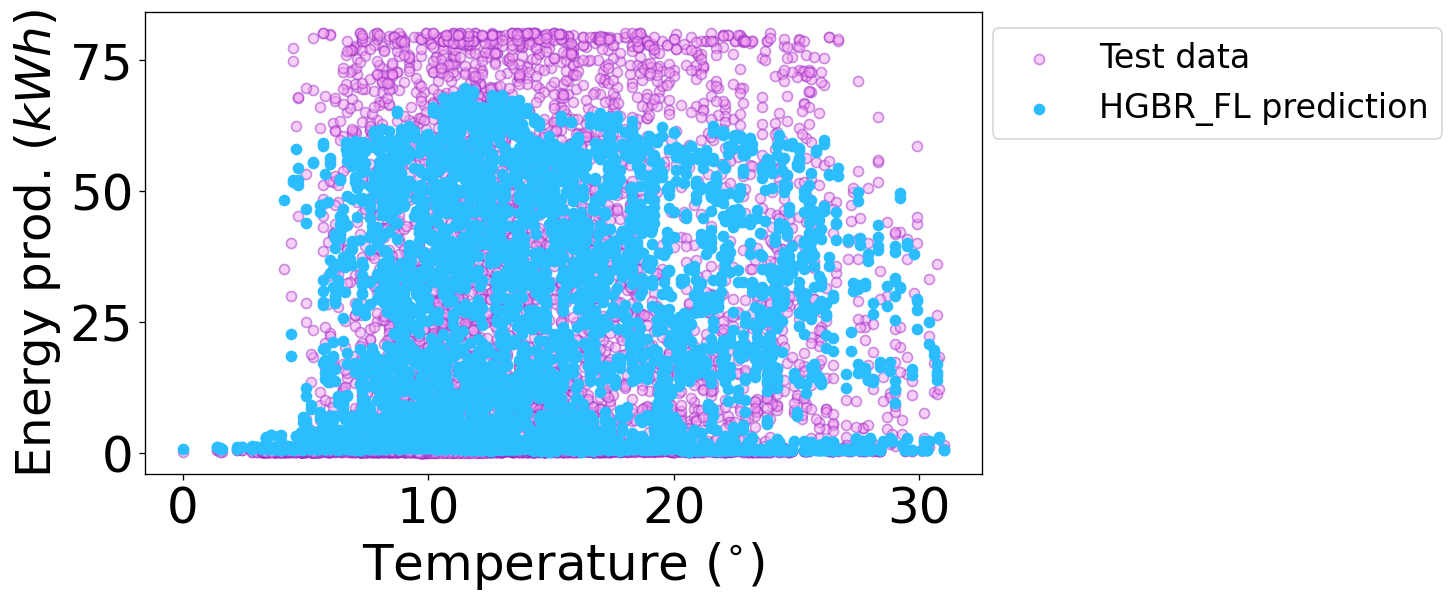

In [273]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test))[:,4], y=(Y_test), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test))[:,4], y=(final_prediction_4_prosum_1_vCPU), color="#2CBDFE", linewidth=1, label='HGBR_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.57,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("hgbr_fl_4_1_prediction.png", format="png", bbox_inches="tight")

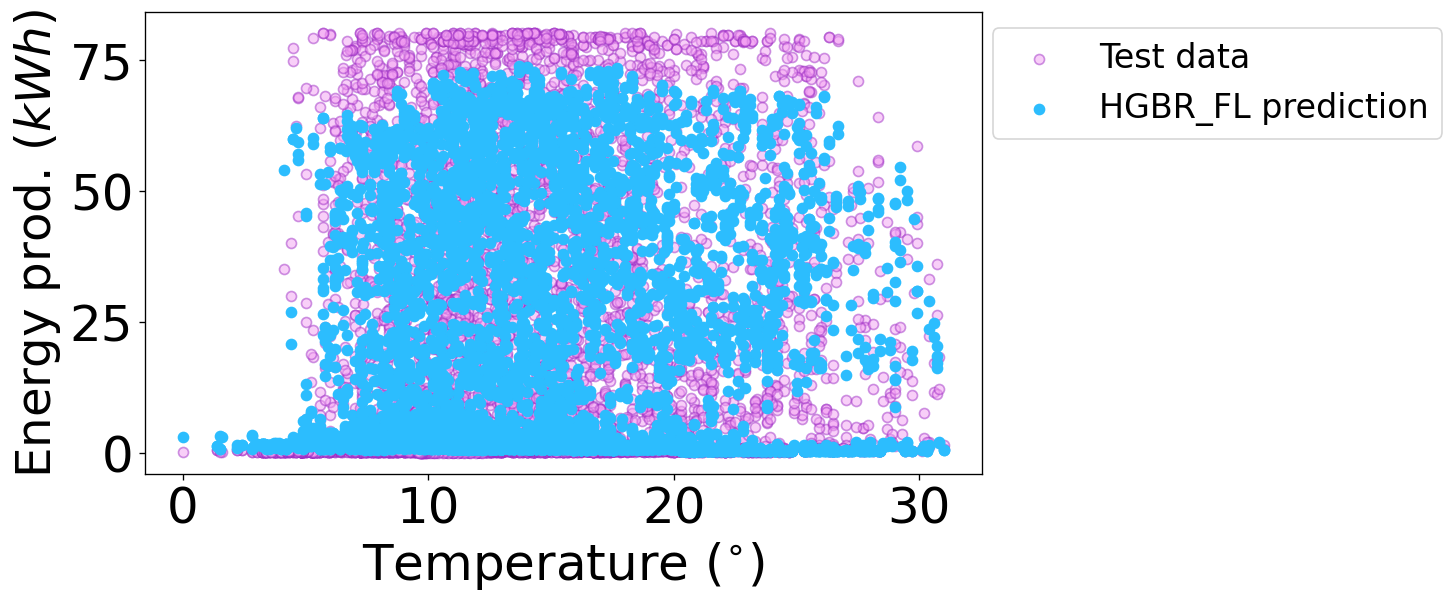

In [274]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test))[:,4], y=(Y_test), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test))[:,4], y=(final_prediction_6_prosum_6_vCPU), color="#2CBDFE", linewidth=1, label='HGBR_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.57,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("hgbr_fl_6_6_prediction.png", format="png", bbox_inches="tight")

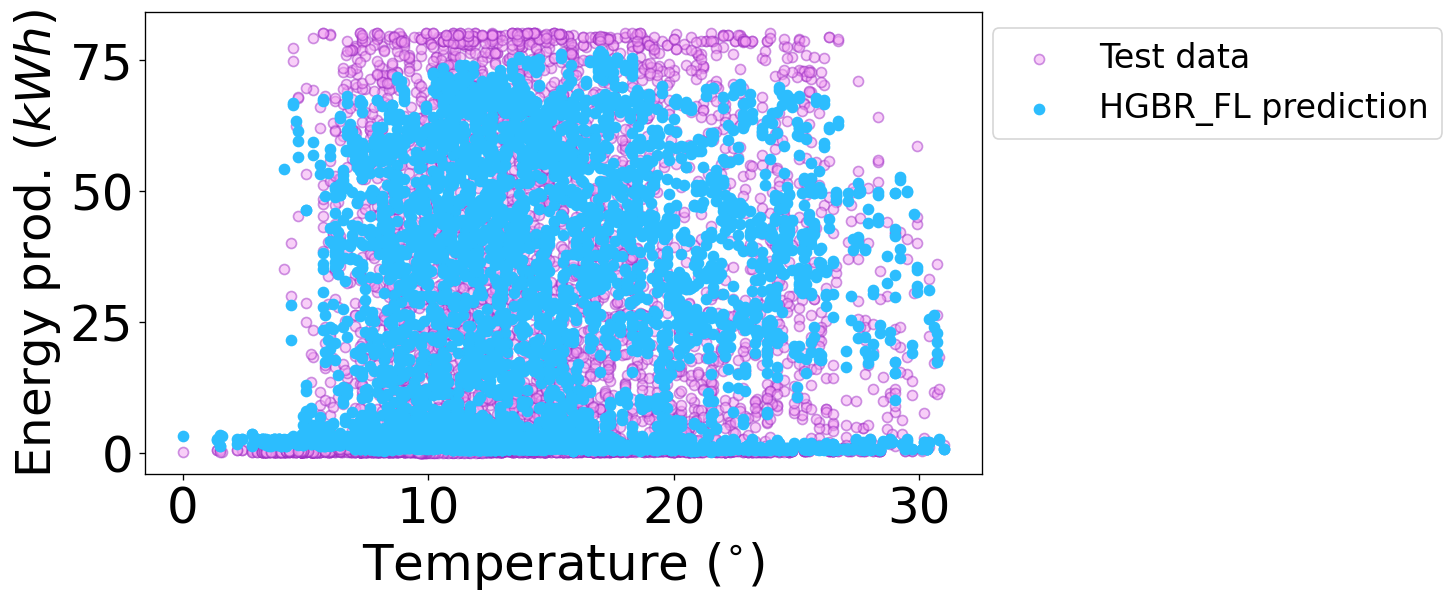

In [275]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test))[:,4], y=(Y_test), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test))[:,4], y=(final_prediction_10_prosum_10_vCPU), color="#2CBDFE", linewidth=1, label='HGBR_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.57,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("hgbr_fl_10_10_prediction.png", format="png", bbox_inches="tight")

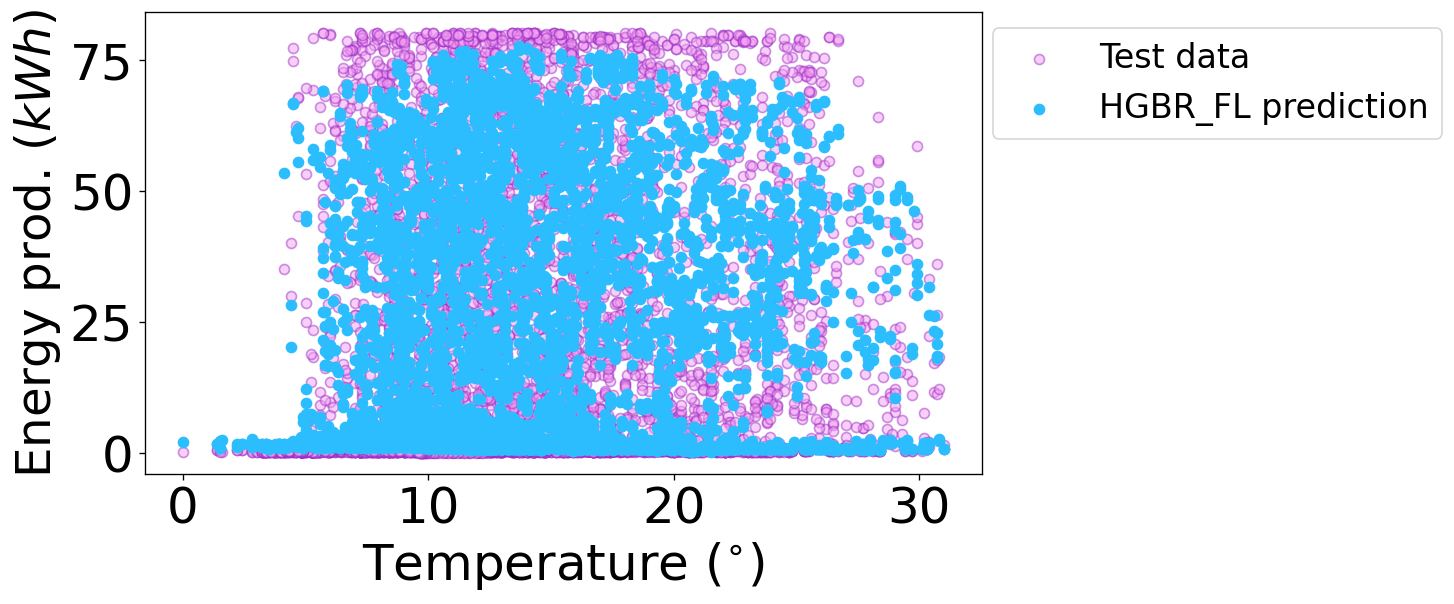

In [276]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.scatter(x=((X_test))[:,4], y=(Y_test), color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5", label='Test data')
plt.subplot().tick_params(labelsize=30)
plt.scatter(x=((X_test))[:,4], y=(final_prediction_12_prosum_12_vCPU), color="#2CBDFE", linewidth=1, label='HGBR_FL prediction')
plt.xlabel('Temperature ($^{\circ}$)', fontsize=30)
plt.ylabel('Energy prod. ($kWh$)', fontsize=29)
plt.legend(bbox_to_anchor =(1.57,1),fontsize=20, ncol=1)
#plt.show()
plt.savefig("hgbr_fl_12_12_prediction.png", format="png", bbox_inches="tight")

In [277]:
mae = mean_absolute_error(Y_test, final_prediction_4_prosum_1_vCPU)
mse = mean_squared_error(Y_test, final_prediction_4_prosum_1_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_4_prosum_4_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 7.155142612874084
MSE : 130.36981307057573
RMSE: 11.417960109869702
R2  : 0.81


In [278]:
mae = mean_absolute_error(Y_test, final_prediction_4_prosum_4_vCPU)
mse = mean_squared_error(Y_test, final_prediction_4_prosum_4_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_4_prosum_4_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 7.155142612874084
MSE : 130.36981307057573
RMSE: 11.417960109869702
R2  : 0.81


In [279]:
mae = mean_absolute_error(Y_test, final_prediction_6_prosum_6_vCPU)
mse = mean_squared_error(Y_test, final_prediction_6_prosum_6_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_6_prosum_6_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.679727050862735
MSE : 116.4392482945267
RMSE: 10.790701937062607
R2  : 0.83


In [280]:
mae = mean_absolute_error(Y_test, final_prediction_8_prosum_8_vCPU)
mse = mean_squared_error(Y_test, final_prediction_8_prosum_8_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_8_prosum_8_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.581332882314695
MSE : 115.14511468197675
RMSE: 10.730569168593842
R2  : 0.83


In [281]:
mae = mean_absolute_error(Y_test, final_prediction_10_prosum_8_vCPU)
mse = mean_squared_error(Y_test, final_prediction_10_prosum_8_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_10_prosum_8_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.6062795424937075
MSE : 115.49119266400344
RMSE: 10.746682867936666
R2  : 0.83


In [282]:
mae = mean_absolute_error(Y_test, final_prediction_10_prosum_10_vCPU)
mse = mean_squared_error(Y_test, final_prediction_10_prosum_10_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_10_prosum_10_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.587102280682535
MSE : 114.74683923147182
RMSE: 10.71199510975765
R2  : 0.83


In [283]:
mae = mean_absolute_error(Y_test, final_prediction_12_prosum_12_vCPU)
mse = mean_squared_error(Y_test, final_prediction_12_prosum_12_vCPU)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, final_prediction_12_prosum_12_vCPU)
#mape = mean_absolute_percentage_error(Y_val, Y_predict_lstm)
#mae = mean_absolute_error(Y_val, Y_predict_lstm)
#mse = mean_squared_error(Y_val, Y_predict_lstm)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.483539181360872
MSE : 114.93219597446806
RMSE: 10.720643449647417
R2  : 0.83


In [284]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor().fit(X_train, Y_train)
Y_predict_hgbr = hgbr.predict(X_test)
Y_predict_hgbr = np.where(Y_predict_hgbr>=0.0, Y_predict_hgbr, 0)

In [285]:
mae = mean_absolute_error(Y_test, Y_predict_hgbr)
mse = mean_squared_error(Y_test, Y_predict_hgbr)
rmse_ = mse ** 0.5
r_two = r2_score(Y_test, Y_predict_hgbr)
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_}")
print(f"R2  : {np.round(r_two,2)}")

MAE : 6.310453221079466
MSE : 116.67010908187962
RMSE: 10.801393849030763
R2  : 0.83


[15.56882520525987, 14.241609588270041, 13.106378277471611, 12.08008705375819, 11.189773075661673, 10.411702542305893, 9.739102604067842, 9.16236217643868, 8.649763523996324, 8.204929376376981, 7.799283377068085, 7.44182339440777, 7.106860880749919, 6.837115770968932, 6.576334193044581, 6.337442302572209, 6.141650792723314, 5.9543695753789, 5.764952400446518, 5.608618825460477, 5.473887823768285, 5.357778998895135, 5.229955195639431, 5.1329549514872514, 5.037828268269578, 4.94553574299529, 4.873957975208186, 4.7917788066168185, 4.7251137164326025, 4.668521452338503, 4.628635089497525, 4.579173774529715, 4.5207848912345945, 4.458262652442592, 4.424300790179347, 4.376830634529449, 4.34813638726158, 4.307908812286158, 4.282890576010454, 4.246568183129056, 4.214433061264907, 4.186783813380091, 4.166712797308219, 4.144984859553223, 4.144094642232907, 4.136652481909692, 4.126284591659808, 4.109654653034889, 4.0977725410388075, 4.078359821576473, 4.060840425754701, 4.041201862859357, 4.030092

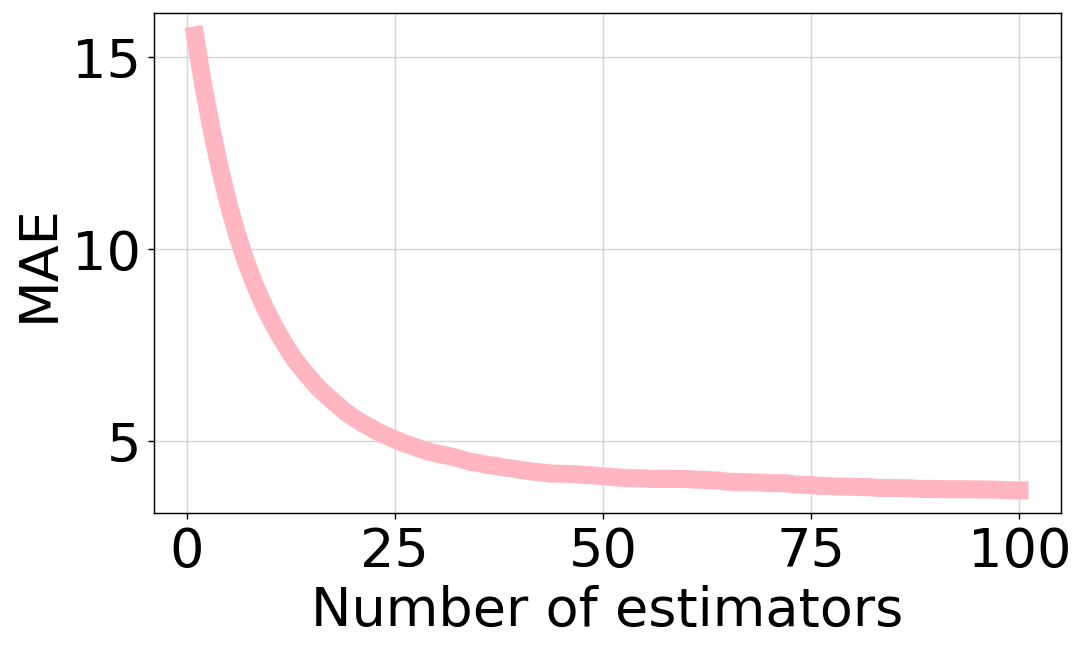

In [286]:
mae = []
for Y_predict_hgbrr in hgbr.staged_predict(X_val):
   mae.append(mean_absolute_error(Y_val, Y_predict_hgbrr))
print(mae)
fig, ax = plt.subplots(figsize=(9, 5), dpi=130)
ax.plot(np.arange(1, len(mae) + 1), mae, color='lightpink', linewidth=10)
plt.subplot().tick_params(labelsize=30)
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("hgbr-validation.pdf", format="pdf", bbox_inches="tight")

In [287]:
init_x_len = X.shape[0]
len_of_x_test_original = X_test.shape[0] - (24*4)

pd.DataFrame(np.hstack((
                        np.array(np.round((X_test)[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 6)), 
                        np.array(np.round((Y_test)[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round((Y_predict_hgbr)[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_4_prosum_1_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_4_prosum_4_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_6_prosum_6_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_8_prosum_8_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_10_prosum_8_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_10_prosum_10_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1),
                        np.array(np.round(final_prediction_12_prosum_12_vCPU[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1)).reshape(-1, 1)
                       )), columns=['Month','Weekday(0=Monday,..., 6=Sunday)','Hour','Minute','Temperature','Ghi', 'Actual Energy (kW)', 'Centralized Prediction (kWh)',
                                     'Predicted Energy_4_prosum_1_vCPU (kWh)', 'Predicted Energy_4_prosum_12_vCPU (kWh)', 'Predicted Energy_6_prosum_6_vCPU (kWh)', 
                                     'Predicted Energy_8_prosum_8_vCPU (kWh)', 'Predicted Energy_10_prosum_8_vCPU (kWh)',  
                                     'Predicted Energy_10_prosum_10_vCPU (kWh)', 'Predicted Energy_12_prosum_12_vCPU (kWh)']
                                     ).to_csv('pv_prediction_data_hgbr_fl.csv', index=False)  # No index to be saved in the file

In [288]:
((54.4-51.3) + (63.8-47.2) + (77.1-72.8) + (80.2-79.7) + (77.5-76.6) + (73.3-59.5))/6

6.533333333333332

<bound method NDFrame.head of      total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]>


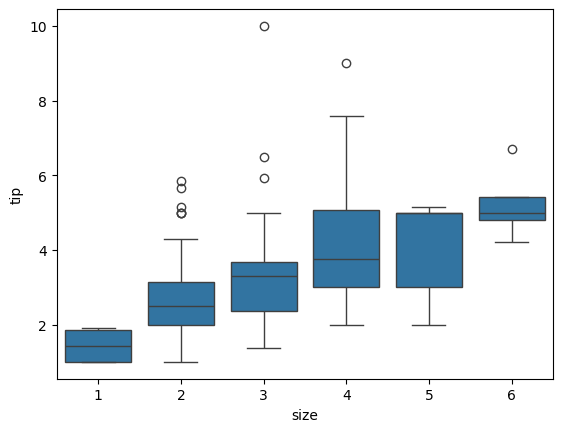

In [289]:
# importing library 
import seaborn as sns 
import matplotlib.pyplot as plt 

# loading seaborn dataset tips 
tdata = sns.load_dataset('tips') 
print(tdata.head)

# creating boxplot 
sns.boxplot(x='size', y='tip', data=tdata) 

# display plot 
plt.show() 

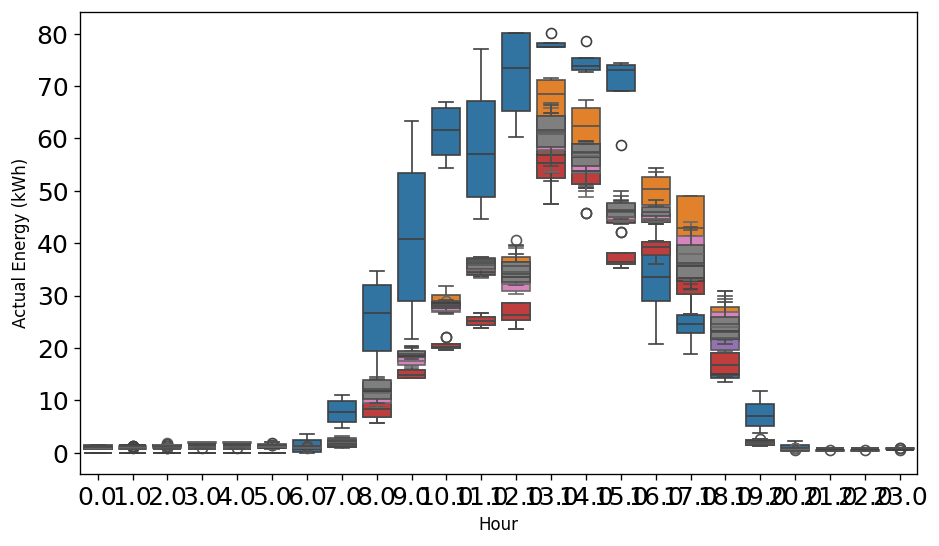

In [290]:
# importing library 
import seaborn as sns 
import matplotlib.pyplot as plt 

len_of_x_test_original = X_test.shape[0] - (24*4) 


# Convert to DataFrame
df = pd.DataFrame({
    'Hour': np.array(np.round((X_test)[len_of_x_test_original:len_of_x_test_original+(24*4)][:,2],0)).ravel(), 
    'Actual Energy (kWh)': np.round(Y_test[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Centralized Predicted Energy (kWh)': np.round(Y_predict_hgbr[len_of_x_test_original+0:len_of_x_test_original+(24*4)], 1).ravel(),
    'Predicted Energy_4_prosum_1_vCPU (kWh)': np.round(final_prediction_4_prosum_1_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Predicted Energy_4_prosum_4_vCPU (kWh)': np.round(final_prediction_4_prosum_4_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Predicted Energy_6_prosum_6_vCPU (kWh)': np.round(final_prediction_6_prosum_6_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Predicted Energy_8_prosum_8_vCPU (kWh)': np.round(final_prediction_8_prosum_8_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Predicted Energy_10_prosum_10_vCPU (kWh)': np.round(final_prediction_10_prosum_10_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'Predicted Energy_12_prosum_12_vCPU (kWh)': np.round(final_prediction_12_prosum_12_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel()
})

# creating boxplot 
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=15)
sns.boxplot(x='Hour', y='Actual Energy (kWh)', data=df) 
sns.boxplot(x='Hour', y='Centralized Predicted Energy (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_4_prosum_1_vCPU (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_4_prosum_4_vCPU (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_6_prosum_6_vCPU (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_8_prosum_8_vCPU (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_10_prosum_10_vCPU (kWh)', data=df) 
sns.boxplot(x='Hour', y='Predicted Energy_12_prosum_12_vCPU (kWh)', data=df) 
# display plot 
plt.show()

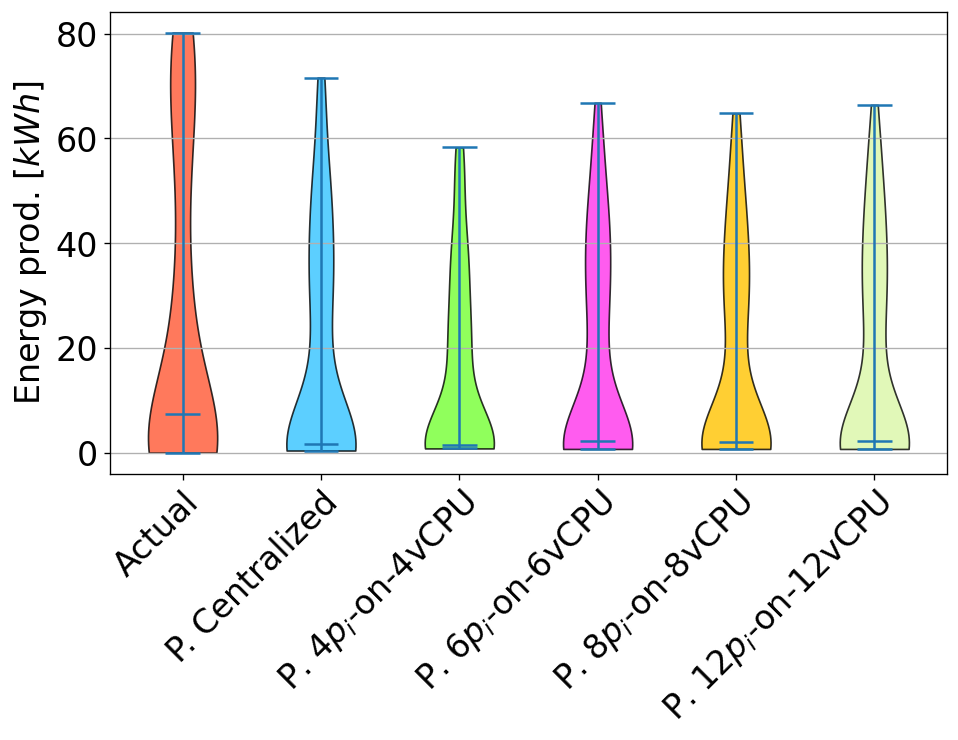

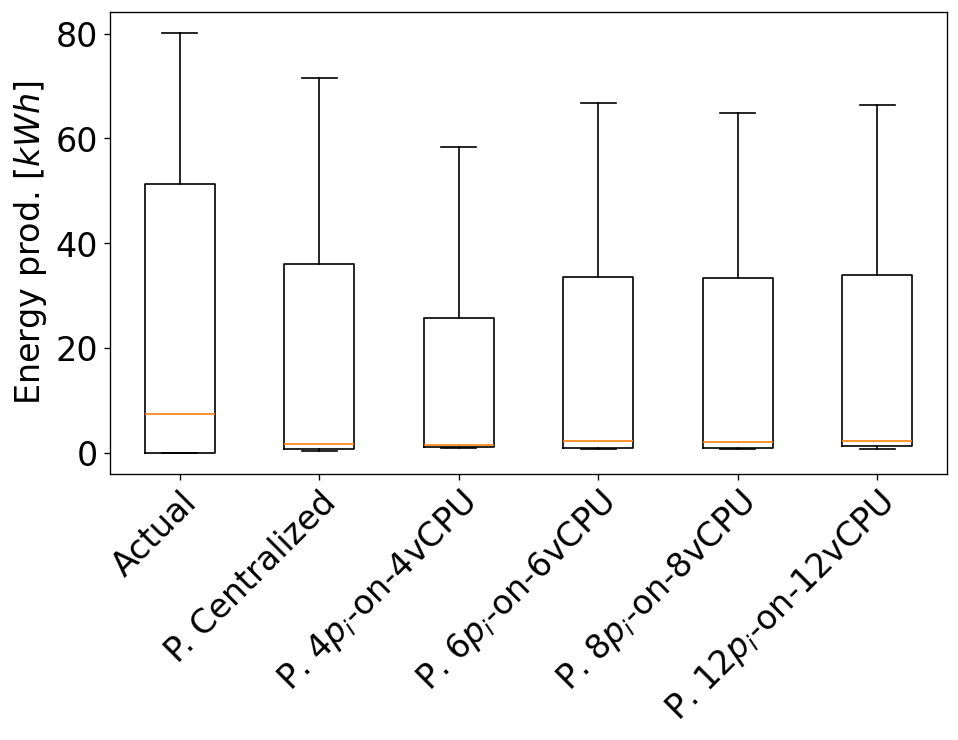

In [291]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs1 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)

# Convert to DataFrame
df = pd.DataFrame({
    'Actual Energy (kW)': np.round(Y_test[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. Centralized (kWh)': np.round(Y_predict_hgbr[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 2$p_i$-on-1vCPU (kWh)': np.round(final_prediction_2_prosum_1_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 4$p_i$-on-1vCPU (kWh)': np.round(final_prediction_4_prosum_1_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 4$p_i$-on-4vCPU (kWh)': np.round(final_prediction_4_prosum_4_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 6$p_i$-on-6vCPU (kWh)': np.round(final_prediction_6_prosum_6_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 8$p_i$-on-8vCPU (kWh)': np.round(final_prediction_8_prosum_8_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 10$p_i$-on-8vCPU (kWh)': np.round(final_prediction_10_prosum_8_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    #'P. 10$p_i$-on-10vCPU (kWh)': np.round(final_prediction_10_prosum_10_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel(),
    'P. 12$p_i$-on-12vCPU (kWh)': np.round(final_prediction_12_prosum_12_vCPU[len_of_x_test_original : len_of_x_test_original + (24*4)], 1).ravel()})
# plot violin plot
parts1 = axs1.violinplot(df, showmeans=False, showmedians=True)
# Define a list of colors (must match number of violins)
colors = ['#FF5733', '#33C3FF', '#75FF33', '#FF33EC', '#FFC300', '#DAF7A6', '#900C3F', '#581845', '#C70039', '#1D8348']
# Color each body of the violin
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i % len(colors)])
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)
# adding horizontal grid lines
axs1.yaxis.grid(True)
axs1.set_xticks([y+1 for y in range((df).shape[1])],
                  labels=['Actual', 'P. Centralized', #'P. 2$p_i$-on-1vCPU', 'P. 4$p_i$-on-1vCPU', 
                          'P. 4$p_i$-on-4vCPU', 'P. 6$p_i$-on-6vCPU',
                          'P. 8$p_i$-on-8vCPU', #'P. 10$p_i$-on-8vCPU', 'P. 10$p_i$-on-10vCPU', 
                          'P. 12$p_i$-on-12vCPU'],
                          rotation=70, fontsize=20)
#for tick in axs1.xaxis.get_majorticklabels():
#    tick.set_horizontalalignment("right")
#axs1.tick_params(axis='x', labelsize=20, labelrotation=70)
axs1.tick_params(axis='y', labelsize=20)
axs1.set_ylabel('Energy prod. [$kWh$]', fontsize=20)
#plt.show()
plt.setp( axs1.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.savefig("violinplot_hgbr_fl.pdf", format="pdf", bbox_inches="tight")

# plot box plot
fig, axs2 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
axs2.boxplot(df)
axs2.set_xticks([y+1 for y in range((df).shape[1])],
                  labels=['Actual', 'P. Centralized', #'P. 2$p_i$-on-1vCPU', 'P. 4$p_i$-on-1vCPU', 
                          'P. 4$p_i$-on-4vCPU', 'P. 6$p_i$-on-6vCPU',
                          'P. 8$p_i$-on-8vCPU', #'P. 10$p_i$-on-8vCPU', 'P. 10$p_i$-on-10vCPU', 
                          'P. 12$p_i$-on-12vCPU'],
                          rotation=70, fontsize=20)
axs1.tick_params(axis='y', labelsize=20)
axs2.set_ylabel('Energy prod. [$kWh$]', fontsize=20)
#plt.show()
plt.setp( axs2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.savefig("boxplot_hgbr_fl.pdf", format="pdf", bbox_inches="tight")

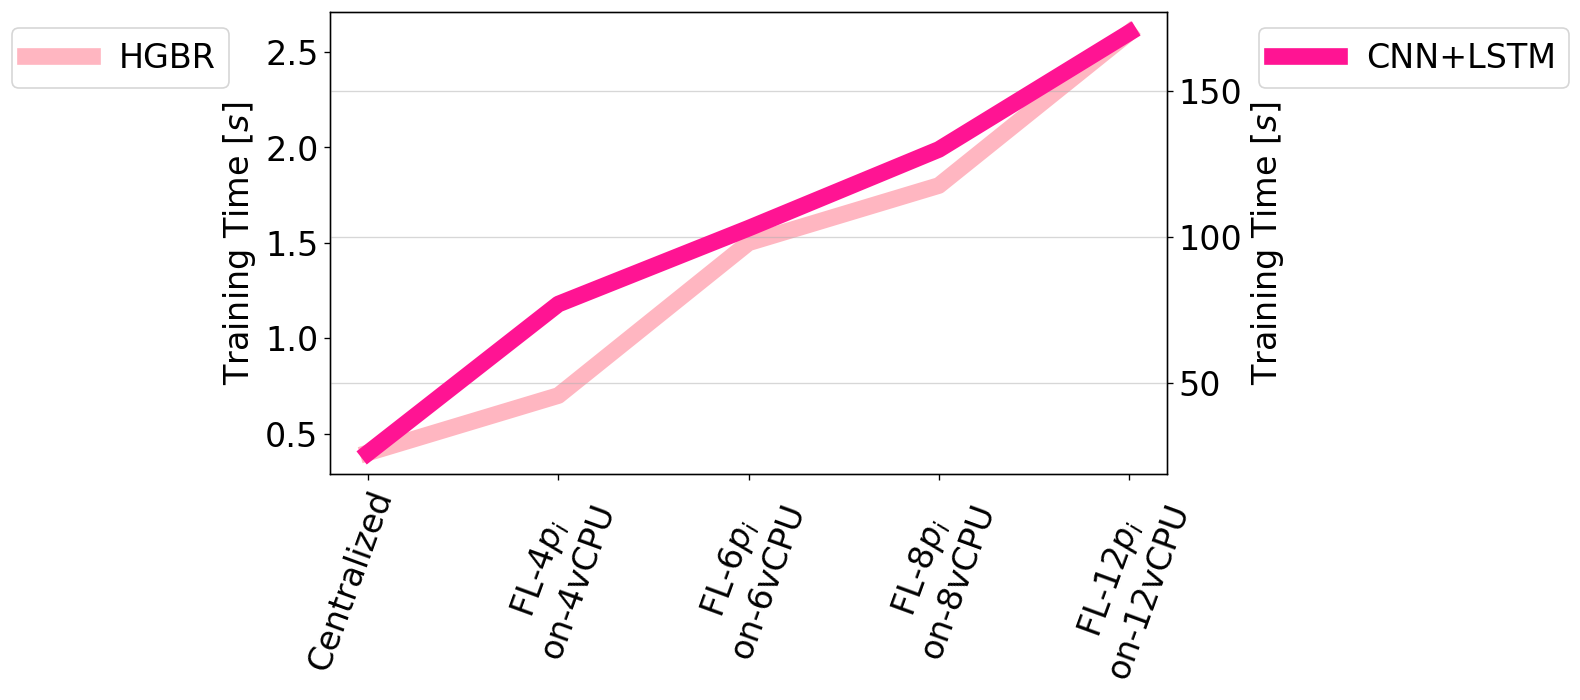

In [292]:
#Time       Cent ,  4-12  , 6-6    ,  8-8    , 12-12 #, 10-10
HGBR_time =     [ 0.4  ,  0.7   , 1.5    ,  1.8       , 2.6] #,  2
LSTM_time =     [26   ,  77    , 103    , 130      , 170] #, 156 

fig, ax1 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
xlab1 = ["Centralized", "FL-4$p_i$", "FL-6$p_i$", "FL-8$p_i$",  "FL-12$p_i$"] #"FL-10$p_i$",
xlab2 = [" ","on-4vCPU","on-6vCPU","on-8vCPU", "on-12vCPU"]#"on-10vCPU",
xlabels = [f"{x1}\n{x2}" for x1, x2, in zip(xlab1,xlab2)]
ax1.set_xticks([y for y in range(len(HGBR_time))],
                  labels=xlabels,
            rotation=70, fontsize=20)
plt.plot(HGBR_time, color='lightpink', linewidth=10, label = "HGBR")
plt.ylabel("Training Time [$s$]", fontsize=20)
plt.legend(loc="upper left",bbox_to_anchor =(-0.4,1),fontsize=20, ncol=1)

ax2 = ax1.twinx()
plt.plot(LSTM_time, marker='+', color='deeppink', linewidth=10, label = "CNN+LSTM")
plt.ylabel("Training Time [$s$]", fontsize=20)
ax2.grid(True, alpha=0.5)
ax2.tick_params(axis='y', labelsize=20)
plt.legend(loc="upper right",bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
plt.savefig("hgbr_lstm_time.pdf", format="pdf", bbox_inches="tight")

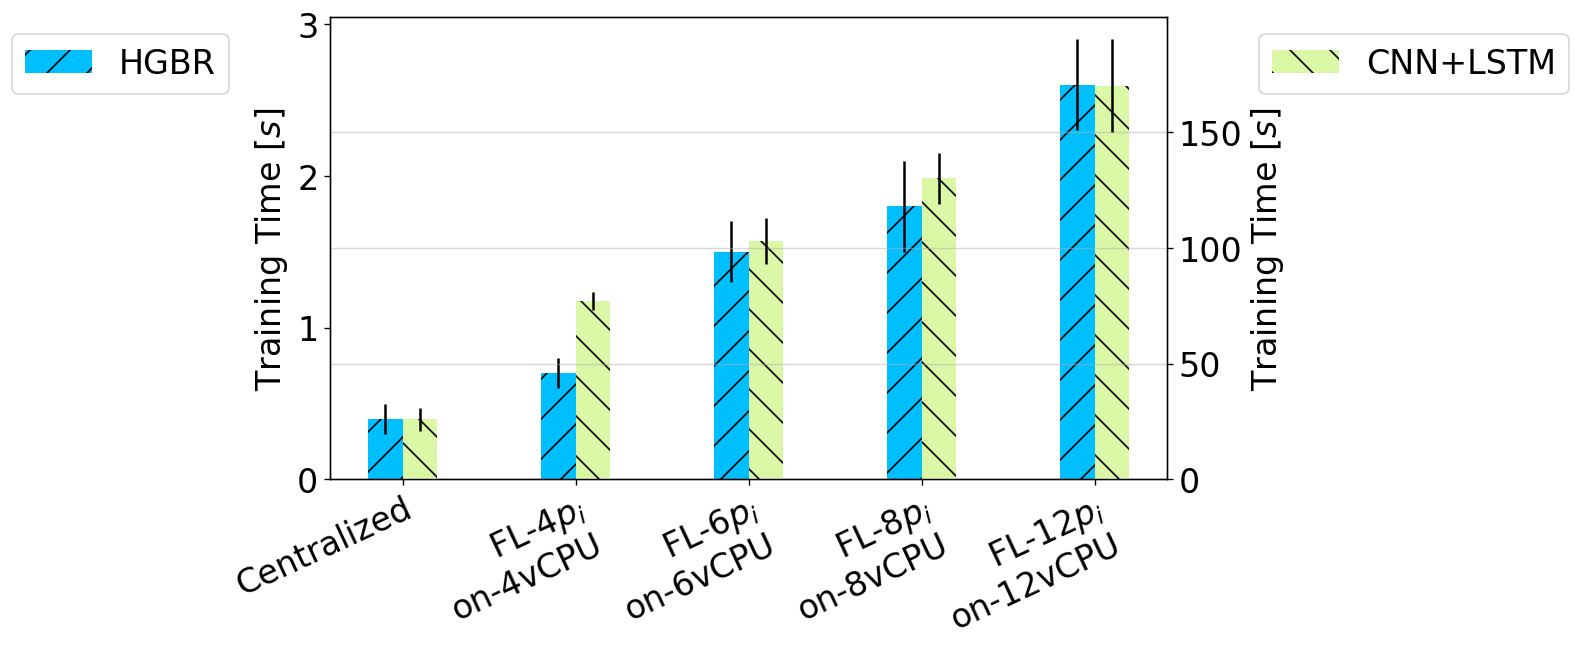

In [297]:
#Time       Cent ,  4-4  , 6-6    ,  8-8   , 12-12 # , 10-10
HGBR_time =        [ 0.4  ,  0.7   , 1.5    ,  1.8      , 2.6] #,  2 
HGBR_time_errors = [.1, .1, .2, .3, .3]

LSTM_time =     [26   ,  77    , 103    , 130      , 170] #, 156 
LSTM_time_errors = [5, 4, 10, 11, 20]

patterns = ['/', '\\', '|', '-']  # Different hatching styles

fig, ax1 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
barWidth=0.2
ticks = range(len(HGBR_time))
ticks1 = [x - barWidth/2 for x in ticks]
ticks2 = [x + barWidth/2 for x in ticks]
xlab1 = ["Centralized", "FL-4$p_i$", "FL-6$p_i$", "FL-8$p_i$", "FL-12$p_i$"] #"FL-10$p_i$", 
xlab2 = ["","on-4vCPU","on-6vCPU","on-8vCPU","on-12vCPU"] #"on-10vCPU",
xlabels = [f"{x1}\n{x2}" for x1, x2, in zip(xlab1,xlab2)]
ax1.set_xticks([y for y in range(len(HGBR_time))],
                  labels=xlabels, fontsize=20)
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=25, ha="right", rotation_mode="anchor") 
plt.bar(ticks1,HGBR_time, yerr= HGBR_time_errors, hatch=patterns[0],  color='deepskyblue',width=barWidth, label="HGBR") #edgecolor='deepskyblue',

plt.ylabel("Training Time [$s$]", fontsize=20)
plt.legend(loc="upper left",bbox_to_anchor =(-0.4,1),fontsize=20, ncol=1)

ax2 = ax1.twinx()
plt.bar(ticks2,LSTM_time, yerr=LSTM_time_errors, hatch=patterns[1],  color='#DAF7A6',width=barWidth, label= "CNN+LSTM") #edgecolor='hotpink',
plt.ylabel("Training Time [$s$]", fontsize=20)
ax2.grid(True, alpha=0.5)
ax2.tick_params(axis='y', labelsize=20)
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=25, ha="right", rotation_mode="anchor") 
plt.legend(loc="upper right",bbox_to_anchor =(1.5,1),fontsize=20, ncol=1)
plt.savefig("hgbr_lstm_time_barchart.pdf", format="pdf", bbox_inches="tight")

Zone: AT
Carbon Intensity: 76 gCO₂eq/kWh
Timestamp: 2025-06-12T16:00:00.000Z
Estimated: True


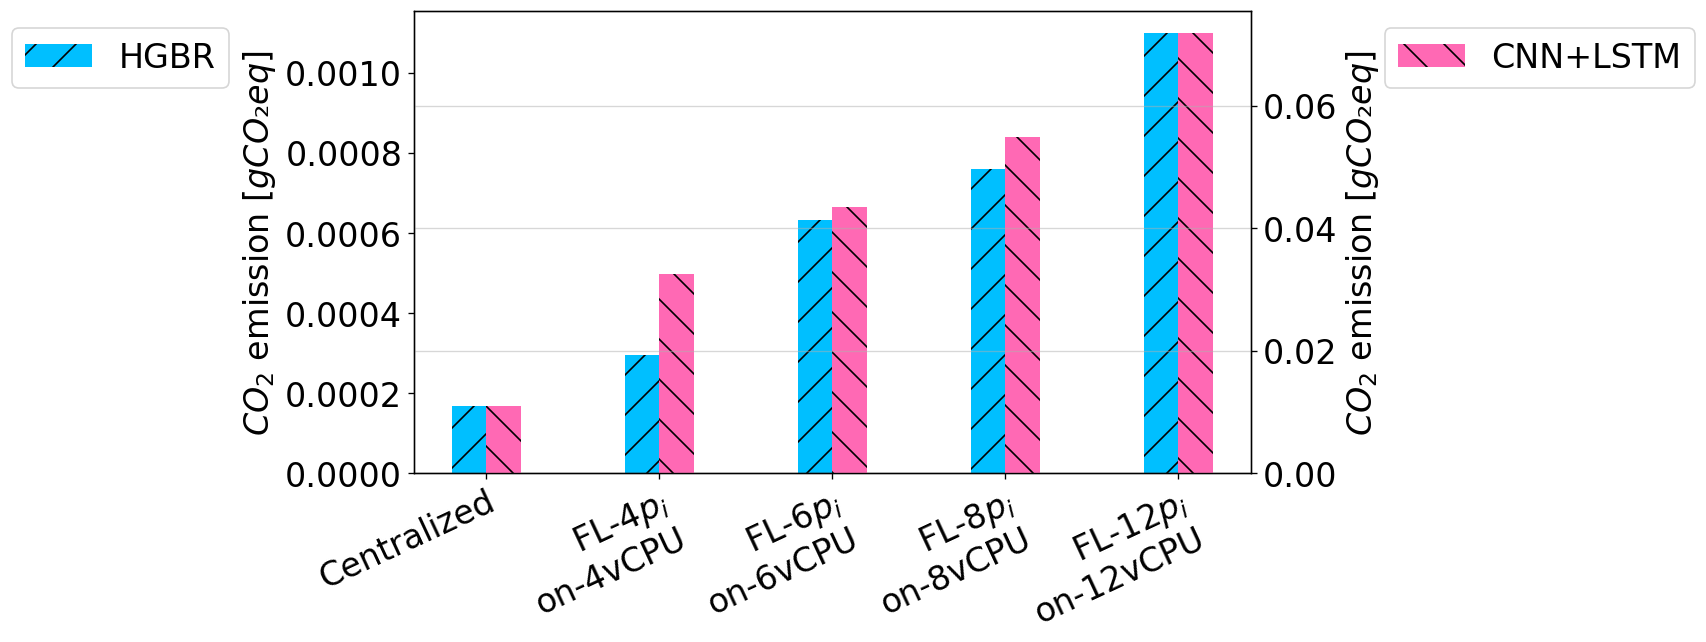

In [298]:
import requests

API_TOKEN = "qi2hvQdtVNrJ9PrGvJZ0"
ZONE = "AT"  # Austria ISO code
BASE_URL = "https://api-access.electricitymaps.com/free-tier/carbon-intensity/latest"

headers = {"auth-token": API_TOKEN}
params = {"zone": ZONE}

resp = requests.get(BASE_URL, headers=headers, params=params)
resp.raise_for_status()
data = resp.json()

print(f"Zone: {data['zone']}")
print(f"Carbon Intensity: {data['carbonIntensity']} gCO₂eq/kWh")
print(f"Timestamp: {data['datetime']}")
print(f"Estimated: {data['isEstimated']}")

Carbon_intensity = data['carbonIntensity'] # benched at September 20, 2024 at 8:00 AM GMT+2
########################################################  
#HGBR_time 
#LSTM_time
########################################################
Active_power = 20 # in watt
########################################################
E_HGBR = [0 for i in range(len(HGBR_time))]
E_LSTM = [0 for i in range(len(HGBR_time))]
CO2_HGBR = [0 for i in range(len(HGBR_time))]
CO2_LSTM = [0 for i in range(len(HGBR_time))]

for i in range(len(HGBR_time)):
    E_HGBR[i] = HGBR_time[i]*Active_power/1000/3600
    CO2_HGBR[i] = E_HGBR[i]*Carbon_intensity

    E_LSTM[i] = LSTM_time[i]*Active_power/1000/3600
    CO2_LSTM[i] = E_LSTM[i]*Carbon_intensity

fig, ax1 = plt.subplots(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
barWidth=0.2
ticks = range(len(HGBR_time))
ticks1 = [x - barWidth/2 for x in ticks]
ticks2 = [x + barWidth/2 for x in ticks]
xlab1 = ["Centralized", "FL-4$p_i$", "FL-6$p_i$", "FL-8$p_i$", "FL-12$p_i$"] #"FL-10$p_i$", 
xlab2 = ["","on-4vCPU","on-6vCPU","on-8vCPU","on-12vCPU"] #"on-10vCPU",
xlabels = [f"{x1}\n{x2}" for x1, x2, in zip(xlab1,xlab2)]
ax1.set_xticks([y for y in range(len(HGBR_time))],
                  labels=xlabels, fontsize=20)
plt.setp( ax1.xaxis.get_majorticklabels(), rotation=25, ha="right", rotation_mode="anchor") 
plt.bar(ticks1, CO2_HGBR, hatch=patterns[0],  color='deepskyblue',width=barWidth, label="HGBR") #yerr= HGBR_time_errors,

plt.ylabel("$CO_2$ emission [$gCO₂eq$]", fontsize=20)
plt.legend(loc="upper left",bbox_to_anchor =(-0.5,1),fontsize=20, ncol=1)

ax2 = ax1.twinx()
plt.bar(ticks2, CO2_LSTM, hatch=patterns[1],  color='hotpink',width=barWidth, label= "CNN+LSTM") #yerr=LSTM_time_errors,
plt.ylabel("$CO_2$ emission [$gCO₂eq$]", fontsize=20)
ax2.grid(True, alpha=0.5)
ax2.tick_params(axis='y', labelsize=20)
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=25, ha="right", rotation_mode="anchor") 
plt.legend(loc="upper right",bbox_to_anchor =(1.55,1),fontsize=20, ncol=1)
plt.savefig("hgbr_lstm_co2_barchart.pdf", format="pdf", bbox_inches="tight")

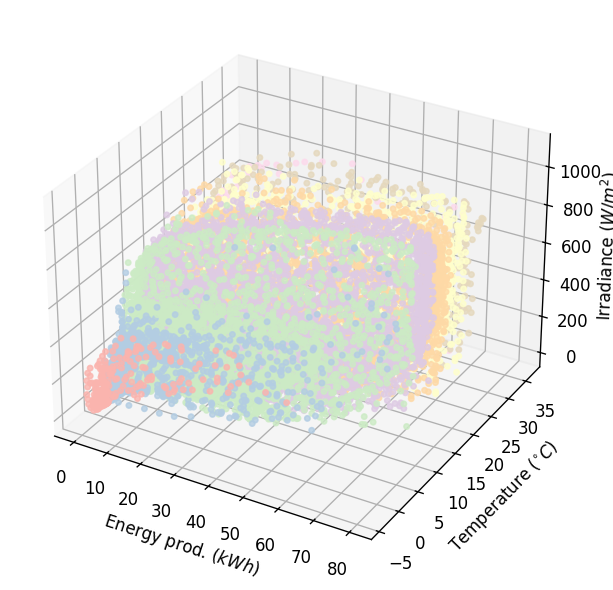

In [299]:
import matplotlib.pyplot as plt

# Create 3D plot
fig = plt.figure(figsize=(9, 5), dpi=120)
ax = fig.add_subplot(111, projection='3d')

# 3D scatter or line
color_values = data_site_solar_generation['ApparentTemperature']
colors = plt.cm.Pastel1((color_values - color_values.min()) / (color_values.max() - color_values.min()))

ax.scatter(data_site_solar_generation["SolarGeneration"],
           data_site_solar_generation["ApparentTemperature"],
           data_site_solar_generation["Ghi"],   
           c=colors,  alpha=0.8, s=10)  # edgecolors='k',
# for scatter plot

# Rotate z-label if needed (optional)
#ax.zaxis.label.set_rotation(90)  # or 0, depending on clarity

# Labels
ax.set_xlabel("Energy prod. ($kWh$)", fontsize=10)
ax.set_ylabel("Temperature ($^{\circ}C$)", fontsize=10)
ax.set_zlabel("Irradiance ($W/m^2$)", fontsize=10, labelpad=2)
# Adjust layout to prevent clipping
plt.tight_layout()
#plt.show()
plt.savefig("RawData.png", format="png", bbox_inches="tight")

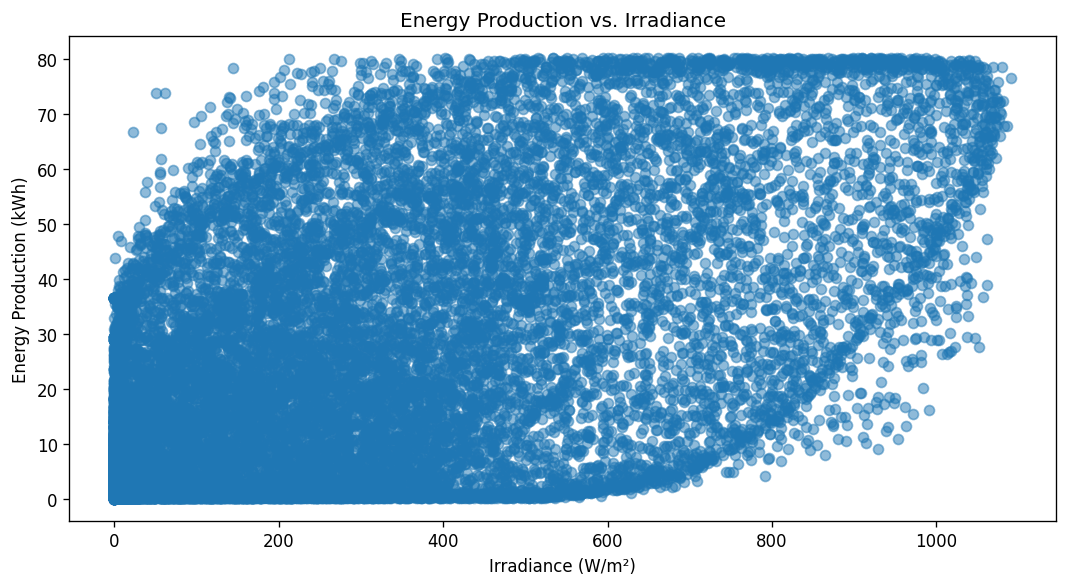

In [300]:
import matplotlib.pyplot as plt

# Create 3D plot
fig = plt.figure(figsize=(9, 5), dpi=120)
plt.scatter( data_site_solar_generation["Ghi"], data_site_solar_generation["SolarGeneration"], alpha=0.5)
plt.xlabel("Irradiance (W/m²)")
plt.ylabel("Energy Production (kWh)")
plt.title("Energy Production vs. Irradiance")
# Adjust layout to prevent clipping
plt.tight_layout()
#plt.show()
plt.savefig("RawData_2d.png", format="png", bbox_inches="tight")